<div style="padding: 15px; border: 1px solid #d4edda; background-color: #d4edda; color: #155724; border-radius: 5px; font-size: 30px;">

  <strong> 1. Imports </strong>
</div>



In [79]:
import pickle
from utils import *
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
import gensim.downloader
#import packages
from keras.models import Model
from keras.layers import Input, LSTM, Dense, TimeDistributed, Bidirectional, Masking
from keras import layers
import tensorflow as tf
import tensorflow.keras as keras
from keras_preprocessing.sequence import pad_sequences
from scipy import sparse
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.naive_bayes import MultinomialNB
from gensim.models import Word2Vec
from keras_preprocessing.sequence import pad_sequences

In [2]:
#make the model start with same weights
tf.random.set_seed(221)

In [3]:
with open('train_val_split.pkl', 'rb') as f:
    data = pickle.load(f)

x_train = data['x_train']
x_val = data['x_val']
y_train = data['y_train']
y_val = data['y_val']

<div style="padding: 15px; border: 1px solid #d4edda; background-color: #d4edda; color: #155724; border-radius: 5px; font-size: 30px;">

  <strong> 2. Feature Engineering </strong>
</div>

## **2.1** Bag of Words

### **2.1.1** Unigrams

In [ ]:
bow_unigrams = CountVectorizer(unigrams=True) # each term is marked as present or not per document - good for short text
X_bow_unigrams = bow_unigrams.fit_transform(x_train['text'])

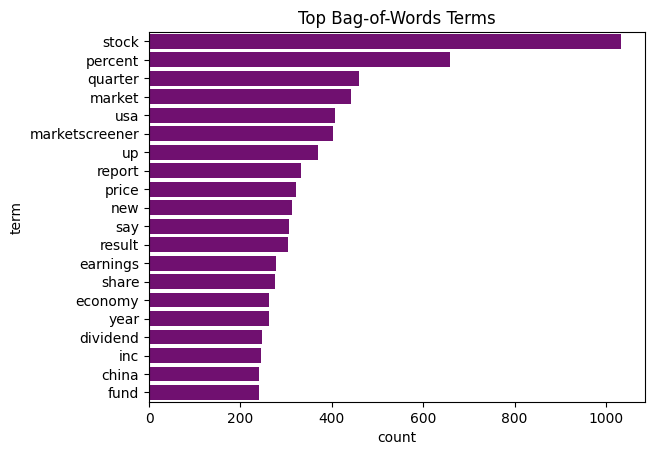

In [ ]:
clean_bow_sum = np.array(X_bow_unigrams.sum(axis=0)).flatten()
clean_terms = bow_unigrams.get_feature_names_out()
clean_top = pd.DataFrame({'term': clean_terms, 'count': clean_bow_sum}).sort_values(by='count', ascending=False).head(20)

sns.barplot(data=clean_top, x='count', y='term', color='purple')
plt.title("Top Bag-of-Words Terms")
plt.show()

### **2.1.2** Unigrams + Bigrams

In [ ]:
bow_bigrams = CountVectorizer(unigrams=True, ngram_range=(1, 2)) # extended BoW to include bigrams to capture short sentiment-bearing phrases (like interest rates for example)
X_bow_bigrams = bow_bigrams.fit_transform(x_train['text'])

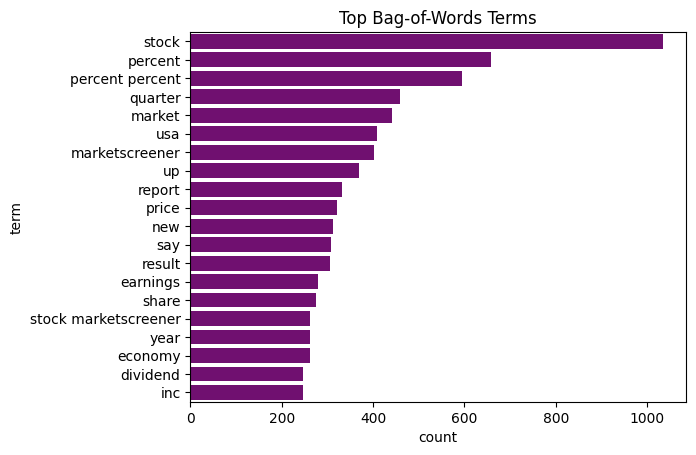

In [ ]:
clean_bow_sum = np.array(X_bow_bigrams.sum(axis=0)).flatten()
clean_terms = bow_bigrams.get_feature_names_out()
clean_top = pd.DataFrame({'term': clean_terms, 'count': clean_bow_sum}).sort_values(by='count', ascending=False).head(20)

sns.barplot(data=clean_top, x='count', y='term', color='purple')
plt.title("Top Bag-of-Words Terms")
plt.show()

## **2.2** TF-IDF

### **2.2.1** Unigrams

In [55]:
tfidf_unigrams = TfidfVectorizer(max_df=0.8, ngram_range=(1,1)) # we are removing terms that appear in >80% of tweets
X_ng_unigrams = tfidf_unigrams.fit_transform(x_train['text']).toarray()

In [56]:
tfidf_unigrams.get_feature_names_out()

array(['aa', 'aal', 'aaoi', ..., 'zyen', 'zynex', 'zynga'], dtype=object)

In [57]:
tfidf_unigrams.vocabulary_

{'nasdaq': 6781,
 'price': 7940,
 'percent': 7551,
 'senior': 9099,
 'note': 7013,
 'future': 4199,
 'up': 12012,
 'november': 7030,
 'nonfarm': 6970,
 'private': 7965,
 'payroll': 7503,
 'consensus': 2243,
 'ticker_econx': 10815,
 'twitter': 11857,
 'user': 12059,
 'explain': 3718,
 'kohl': 5680,
 'stock': 9730,
 'got': 4433,
 'obliterated': 7101,
 'reporting': 8502,
 'earnings': 3232,
 'agilysys': 260,
 'restaurant': 8564,
 'find': 3932,
 'sustainable': 9946,
 'method': 6448,
 'limiting': 5945,
 'food': 4045,
 'waste': 12304,
 'holiday': 4818,
 'make': 6173,
 'retirement': 8592,
 'top': 11647,
 'ranked': 8236,
 'mutual': 6738,
 'fund': 4186,
 'february': 3858,
 'could': 2391,
 'applied': 590,
 'dna': 3045,
 'science': 8990,
 'inc': 5094,
 'apdn': 569,
 'see': 9059,
 'reversal': 8616,
 'breaking': 1377,
 'week': 12353,
 'low': 6074,
 'lamp': 5746,
 'news': 6884,
 'usmca': 12062,
 'affect': 225,
 'usa': 12051,
 'steelmaker': 9693,
 'auto': 818,
 'manufacturer': 6220,
 'manchester': 620

In [58]:
# get the IDF score for each term
idf_dict = dict(zip(tfidf_unigrams.get_feature_names_out(), tfidf_unigrams.idf_))

# Get the first 10 items
idf_dict_10 = dict(list(idf_dict.items())[4100:4110])

print(idf_dict_10)

{'four': 6.996059238486293, 'fourth': 5.9515141710884585, 'fowl': 9.247351037092788, 'fox': 8.554203856532842, 'foxbusiness': 8.554203856532842, 'foxconn': 8.554203856532842, 'foxnews': 9.247351037092788, 'fpga': 9.247351037092788, 'fpp': 9.247351037092788, 'fpt': 9.247351037092788}


### **2.2.2** Bigrams

In [59]:
tfidf_bigrams = TfidfVectorizer(max_df=0.8, ngram_range=(1,2))
X_ng_bigrams = tfidf_bigrams.fit_transform(x_train['text']).toarray()

In [60]:
tfidf_bigrams.get_feature_names_out()

array(['aa', 'aa cc', 'aal', ..., 'zynga', 'zynga nasdaq', 'zynga share'],
      dtype=object)

In [61]:
tfidf_bigrams.vocabulary_

{'nasdaq': 31116,
 'price': 36807,
 'percent': 34740,
 'senior': 42616,
 'note': 32303,
 'nasdaq price': 31201,
 'price percent': 36870,
 'percent percent': 34908,
 'percent senior': 34950,
 'senior note': 42629,
 'future': 19130,
 'up': 52401,
 'future up': 19176,
 'november': 32386,
 'nonfarm': 32196,
 'private': 37013,
 'payroll': 34549,
 'consensus': 10005,
 'ticker_econx': 49004,
 'november nonfarm': 32399,
 'nonfarm private': 32198,
 'private payroll': 37023,
 'payroll consensus': 34550,
 'consensus ticker_econx': 10021,
 'twitter': 51771,
 'user': 53151,
 'explain': 16662,
 'kohl': 25824,
 'stock': 45403,
 'got': 20386,
 'obliterated': 32723,
 'reporting': 39606,
 'earnings': 14509,
 'twitter user': 51788,
 'user explain': 53154,
 'explain kohl': 16663,
 'kohl stock': 25835,
 'stock got': 45477,
 'got obliterated': 20389,
 'obliterated reporting': 32724,
 'reporting earnings': 39608,
 'agilysys': 927,
 'restaurant': 39887,
 'find': 17839,
 'sustainable': 46648,
 'method': 29606,

In [62]:
# get the IDF score for each term
idf_dict = dict(zip(tfidf_bigrams.get_feature_names_out(), tfidf_bigrams.idf_))

# Get the first 10 items
idf_dict_10 = dict(list(idf_dict.items())[4100:4110])

print(idf_dict_10)

{'baxterinternational stock': 9.247351037092788, 'bayer': 8.331060305218632, 'bayer asks': 9.247351037092788, 'bayer face': 9.247351037092788, 'bayer plaintiff': 9.247351037092788, 'bayer seek': 9.247351037092788, 'bayer stock': 9.247351037092788, 'bayway': 9.247351037092788, 'bayway refinery': 9.247351037092788, 'bazooka': 8.841885928984624}


## **2.3** Word 2 Vec

In [86]:
# Tokenize training and validation tweets
tokenized_train = [tweet.split() for tweet in x_train['text']]
tokenized_val = [tweet.split() for tweet in x_val['text']]

In [87]:
corpus = x_train['text']

#get list with lenghts of sentences
train_len = []
for i in corpus:
    train_len.append(len(i))

max(train_len)

266

In [88]:
model = Word2Vec(
    sentences=corpus,
    vector_size=266,    # size of the embedding vectors 
    window=2,         # context window size
    min_count=1,      # minimum word frequency to include
    sg=1              # 1 for skip-gram; 0 for CBOW
)

In [91]:
vector_size = model.vector_size

In [ ]:
# Function to convert tokens into mean embedding vector
def tweet_to_vec(tokens, model, size):
    vectors = [model.wv[word] for word in tokens if word in model.wv]
    return np.mean(vectors, axis=0) if vectors else np.zeros(size)

# Apply to train and validation sets
X_train_vec = np.array([tweet_to_vec(tokens, model, vector_size) for tokens in tokenized_train])
X_val_vec = np.array([tweet_to_vec(tokens, model, vector_size) for tokens in tokenized_val])

In [93]:
from sklearn.linear_model import LogisticRegression
# You already have y_train and y_val
clf = LogisticRegression(max_iter=200)
clf.fit(X_train_vec, y_train)

# Predict
y_pred_w2v = clf.predict(X_val_vec)

# Evaluate
print(classification_report(y_val, y_pred_w2v))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       288
           1       0.73      0.04      0.08       385
           2       0.65      1.00      0.79      1236

    accuracy                           0.65      1909
   macro avg       0.46      0.35      0.29      1909
weighted avg       0.57      0.65      0.53      1909



/Users/brunasimoes/Desktop/nova_ims/2_semester/Trimestral/Text Mining/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/brunasimoes/Desktop/nova_ims/2_semester/Trimestral/Text Mining/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/brunasimoes/Desktop/nova_ims/2_semester/Trimestral/Text Mining/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no pr

In [95]:
knn = KNeighborsClassifier(n_neighbors=10) 
knn.fit(X_train_vec, y_train)

y_pred_knn = knn.predict(X_val_vec)

print(classification_report(y_val, y_pred_knn))

              precision    recall  f1-score   support

           0       0.50      0.00      0.01       288
           1       0.56      0.05      0.09       385
           2       0.65      0.99      0.79      1236

    accuracy                           0.65      1909
   macro avg       0.57      0.35      0.30      1909
weighted avg       0.61      0.65      0.53      1909



## **2.4** Glove

In [ ]:
model_name = 'glove-twitter'
emb_size = 50 #start small than increase to find the best value

In [ ]:
w2v = gensim.downloader.load(f'{model_name}-{emb_size}')

In [ ]:
#get word embeddings from documents
def corpus2vec(corpus, w2v):
    index_set = set(w2v.index_to_key)  # Faster lookup
    word_vec = w2v.get_vector           # Alias for speed
    return [
        [word_vec(word) for word in doc.split() if word in index_set]
        for doc in tqdm(corpus)
    ]

In [ ]:
x_train_vect = corpus2vec(x_train, w2v)

In [ ]:
x_val_vect = corpus2vec(x_val, w2v)

In [ ]:
#Padding
#make all sentences the same size - model input must be of the same size
x_pad = pad_sequences(maxlen=max(train_len),sequences=x_train_vect, padding="post", dtype='float64')

In [ ]:
#Most turn output into one hot encoded matrix
y_train_encoded = tf.one_hot(y_train, depth=3)

#

<div style="padding: 15px; border: 1px solid #d4edda; background-color: #d4edda; color: #155724; border-radius: 5px; font-size: 30px;">

  <strong> 3. Models </strong>
</div>


## **3.1** K-Means

### **3.1.1** BoW unigrams

In [ ]:
modelknn = KNeighborsClassifier(n_neighbors = 10, metric = 'cosine', weights = 'distance')
modelknn.fit(X_bow_unigrams,y_train)

KNeighborsClassifier(metric='cosine', n_neighbors=10, weights='distance')

In [ ]:
y_pred_knn_bow_unigrams = modelknn.predict(bow_unigrams.transform(x_val['text']))

In [ ]:
print(set(y_val))
print(set(y_pred_knn_bow_unigrams))

{0, 1, 2}
{0, 1, 2}


In [ ]:
print(classification_report(y_pred_knn_bow_unigrams, y_val))

              precision    recall  f1-score   support

           0       0.41      0.74      0.52       159
           1       0.64      0.66      0.65       374
           2       0.92      0.83      0.87      1376

    accuracy                           0.79      1909
   macro avg       0.66      0.74      0.68      1909
weighted avg       0.82      0.79      0.80      1909



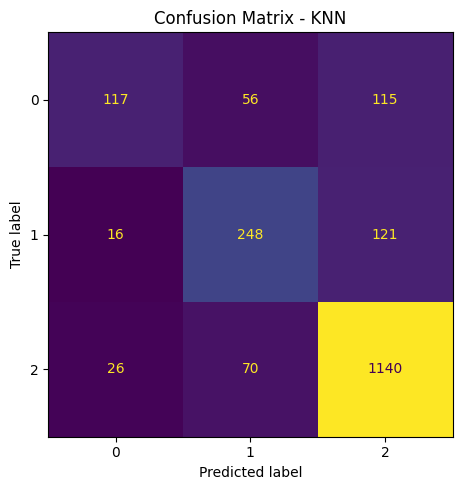

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# Compute the confusion matrix
cm = confusion_matrix(y_val, y_pred_knn_bow_unigrams)

# Display it
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
fig, ax = plt.subplots(figsize=(6, 5))
disp.plot(ax=ax, colorbar=False)
ax.set_title("Confusion Matrix - KNN")
plt.tight_layout()
plt.show()

### **3.1.2** BoW bigrams

In [ ]:
modelknn = KNeighborsClassifier(n_neighbors = 10, metric = 'cosine', weights = 'distance')
modelknn.fit(X_bow_bigrams,y_train)

KNeighborsClassifier(metric='cosine', n_neighbors=10, weights='distance')

In [ ]:
y_pred_knn_bow_bigrams = modelknn.predict(bow_bigrams.transform(x_val['text']))

In [ ]:
print(set(y_val))
print(set(y_pred_knn_bow_bigrams))

{0, 1, 2}
{0, 1, 2}


In [ ]:
print(classification_report(y_pred_knn_bow_bigrams, y_val))

              precision    recall  f1-score   support

           0       0.38      0.69      0.49       158
           1       0.64      0.67      0.65       369
           2       0.92      0.83      0.87      1382

    accuracy                           0.78      1909
   macro avg       0.65      0.73      0.67      1909
weighted avg       0.82      0.78      0.80      1909



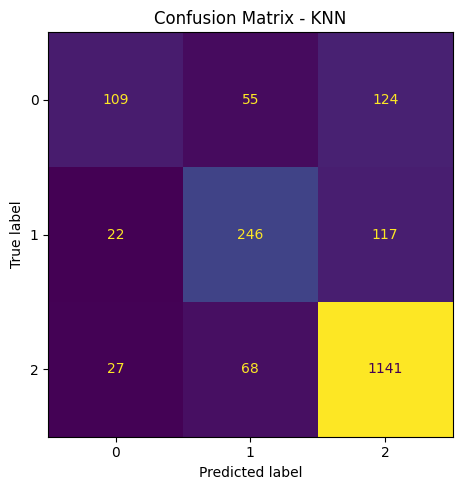

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# Compute the confusion matrix
cm = confusion_matrix(y_val, y_pred_knn_bow_bigrams)

# Display it
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
fig, ax = plt.subplots(figsize=(6, 5))
disp.plot(ax=ax, colorbar=False)
ax.set_title("Confusion Matrix - KNN")
plt.tight_layout()
plt.show()

### **3.1.3** TF-IDF unigrams

In [54]:
modelknn = KNeighborsClassifier(n_neighbors = 10, metric = 'cosine', weights = 'distance')
modelknn.fit(X_ng_unigrams,y_train)

KNeighborsClassifier(metric='cosine', n_neighbors=10, weights='distance')

In [68]:
y_pred_knn_ng_unigrams = modelknn.predict(tfidf_unigrams.transform(x_val['text']))

In [70]:
print(classification_report(y_pred_knn_ng_unigrams, y_val))

              precision    recall  f1-score   support

           0       0.44      0.72      0.55       176
           1       0.65      0.69      0.67       364
           2       0.93      0.84      0.88      1369

    accuracy                           0.80      1909
   macro avg       0.67      0.75      0.70      1909
weighted avg       0.83      0.80      0.81      1909



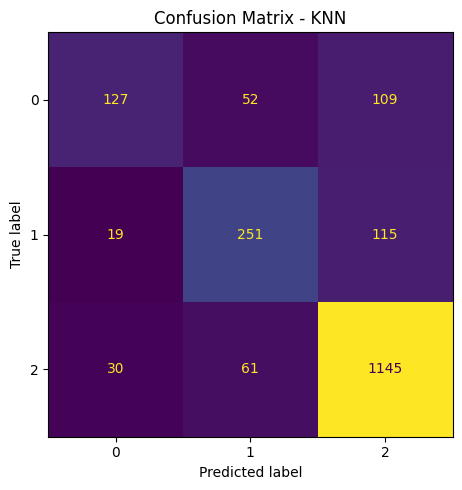

In [71]:
# Compute the confusion matrix
cm = confusion_matrix(y_val, y_pred_knn_ng_unigrams)

# Display it
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
fig, ax = plt.subplots(figsize=(6, 5))
disp.plot(ax=ax, colorbar=False)
ax.set_title("Confusion Matrix - KNN")
plt.tight_layout()
plt.show()

### **3.1.4** TF-IDF bigrams

In [72]:
modelknn = KNeighborsClassifier(n_neighbors = 10, metric = 'cosine', weights = 'distance')
modelknn.fit(X_ng_bigrams,y_train)

KNeighborsClassifier(metric='cosine', n_neighbors=10, weights='distance')

In [75]:
y_pred_knn_ng_bigrams = modelknn.predict(tfidf_bigrams.transform(x_val['text']))

In [76]:
print(classification_report(y_pred_knn_ng_bigrams, y_val))

              precision    recall  f1-score   support

           0       0.43      0.71      0.53       173
           1       0.64      0.68      0.66       362
           2       0.92      0.83      0.87      1374

    accuracy                           0.79      1909
   macro avg       0.66      0.74      0.69      1909
weighted avg       0.82      0.79      0.80      1909



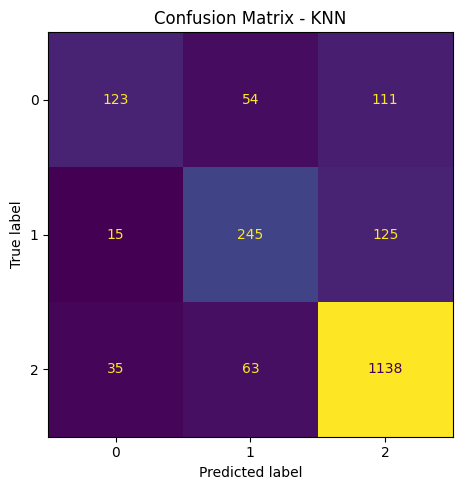

In [77]:
# Compute the confusion matrix
cm = confusion_matrix(y_val, y_pred_knn_ng_bigrams)

# Display it
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
fig, ax = plt.subplots(figsize=(6, 5))
disp.plot(ax=ax, colorbar=False)
ax.set_title("Confusion Matrix - KNN")
plt.tight_layout()
plt.show()

## **3.2** Naive Bayes

### **3.2.1** BoW unigrams

In [ ]:
nb = MultinomialNB()
nb.fit(X_bow_unigrams.toarray(), y_train)

MultinomialNB()

In [ ]:
X_val_bow = bow_unigrams.transform(x_val['text']) 
y_pred_nb_bow_unigrams = nb.predict(X_val_bow)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_val, y_pred_nb_bow_unigrams))
from sklearn.metrics import confusion_matrix
confusion_matrix(y_pred_nb_bow_unigrams, y_val)

              precision    recall  f1-score   support

           0       0.76      0.44      0.56       288
           1       0.71      0.63      0.66       385
           2       0.82      0.93      0.87      1236

    accuracy                           0.80      1909
   macro avg       0.76      0.67      0.70      1909
weighted avg       0.79      0.80      0.78      1909



array([[ 126,   12,   28],
       [  43,  241,   56],
       [ 119,  132, 1152]])

### **3.2.2** BoW bigrams

In [ ]:
nb = MultinomialNB()
nb.fit(X_bow_bigrams.toarray(), y_train)

MultinomialNB()

In [ ]:
X_val_bow = bow_bigrams.transform(x_val['text']) 
y_pred_nb_bow_bigrams = nb.predict(X_val_bow)

In [ ]:
print(classification_report(y_val, y_pred_nb_bow_bigrams))

              precision    recall  f1-score   support

           0       0.81      0.42      0.55       288
           1       0.76      0.61      0.68       385
           2       0.81      0.95      0.88      1236

    accuracy                           0.80      1909
   macro avg       0.79      0.66      0.70      1909
weighted avg       0.80      0.80      0.79      1909



array([[ 120,   13,   16],
       [  33,  236,   42],
       [ 135,  136, 1178]])

## **2.5** Model (Glove)

In [ ]:
'''model input in the shape(number of words per doc, word embedding size)'''
input_ = Input(shape=(max(train_len), emb_size))

'''mask layer to avoid model from considering padding vectors'''
mask_layer = Masking(mask_value=0)
mask = mask_layer(input_)

'''BiLSTM layer'''
lstm = Bidirectional(LSTM(units=32))(mask)

'''activation layer'''
act = Dense(3, activation='softmax')(lstm)

'''model input and output'''
model = Model(input_, act)

'''model loss function and evaluation metrics'''

model.compile(optimizer="adam",
              loss="categorical_crossentropy",
              metrics=["categorical_accuracy"]) #we have class imbalance, change this 
model.summary()

In [ ]:
x_val_pad = pad_sequences(maxlen=max(train_len),sequences=x_val_vect, padding="post", dtype='float64')
y_val_encoded = tf.one_hot(y_val, depth=3)

In [ ]:
history=model.fit(x_pad, y_train_encoded,
          batch_size=16,
          epochs=10,
          validation_data=(x_val_pad, y_val_encoded))

In [ ]:
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])

## **2.6** Predict

In [ ]:
pred_y = model.predict(x_val_pad)

In [ ]:
y_pred = []
for doc in pred_y:
    y_pred.append(np.argmax(doc, axis=None, out=None))

In [ ]:
print(classification_report(y_val_encoded, y_pred))